In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# Add scripts to path
sys.path.append("../Scripts")
from nonconvex_portfolio_optimizer import optimize_nonconvex
from convex_portfolio_optimizer import load_data

# Ensure output directory exists
os.makedirs("../Results/optimized_portfolios", exist_ok=True)

print("="*70)
print("NON-CONVEX PORTFOLIO OPTIMIZATION")
print("="*70)

NON-CONVEX PORTFOLIO OPTIMIZATION


In [2]:
try:
    mu = pd.read_json("../Results/processed/mean_returns.json", typ="series")
    cov = pd.read_csv("../Results/processed/cov_matrix.csv", index_col=0)
    tickers = pd.read_csv("../Results/processed/tickers.txt", header=None)[0].tolist()
    print(f"Successfully loaded {len(tickers)} assets.")
except FileNotFoundError:
    print("Error: Could not find data files. Make sure you ran 01_Data_Preprocessing.ipynb first.")
    raise

Successfully loaded 467 assets.


In [3]:
k_assets = 5 
lam_val = 10

print(f"\nConstraint: Select exactly {k_assets} assets out of {len(tickers)}")
print("Method: Cubic term penalty + Cardinality constraint (simulated)")


Constraint: Select exactly 5 assets out of 467
Method: Cubic term penalty + Cardinality constraint (simulated)


In [4]:
weights, obj_val, info = optimize_nonconvex(
    mu, cov, tickers, 
    lam=lam_val, 
    max_alloc=0.5, 
    k=k_assets
)

print("\nOptimization Status:", info['status'])
print(f"Return: {info['portfolio_return']:.4%}")
print(f"Risk:   {info['portfolio_risk']:.4%}")
print(f"Sharpe: {info['sharpe_ratio']:.4f}")

active_assets = np.sum(weights > 1e-4)
print(f"Number of assets selected: {active_assets}")


[INFO] Strict MIQP Solver failed (Either candidate conic solvers (['SCIPY']) do not support the cones output by the problem (SOC, NonNeg, Zero), or there are not enough constraints in the problem.).
[INFO] Switching to Heuristic Cardinality Solution (Select Top K -> Optimize)...

Optimization Status: Heuristic Optimal
Return: 0.1587%
Risk:   0.9726%
Sharpe: 0.1631
Number of assets selected: 5


In [5]:
result_data = {
    "weights": weights.tolist(),
    "portfolio_return": info['portfolio_return'],
    "portfolio_risk": info['portfolio_risk'],
    "sharpe_ratio": info['sharpe_ratio'],
    "description": "Non-Convex (Cardinality + Cubic Penalty)"
}

with open("../Results/optimized_portfolios/nonconvex_solution.json", "w") as f:
    json.dump(result_data, f, indent=4)
print("\n[SUCCESS] Results saved to nonconvex_solution.json")


[SUCCESS] Results saved to nonconvex_solution.json


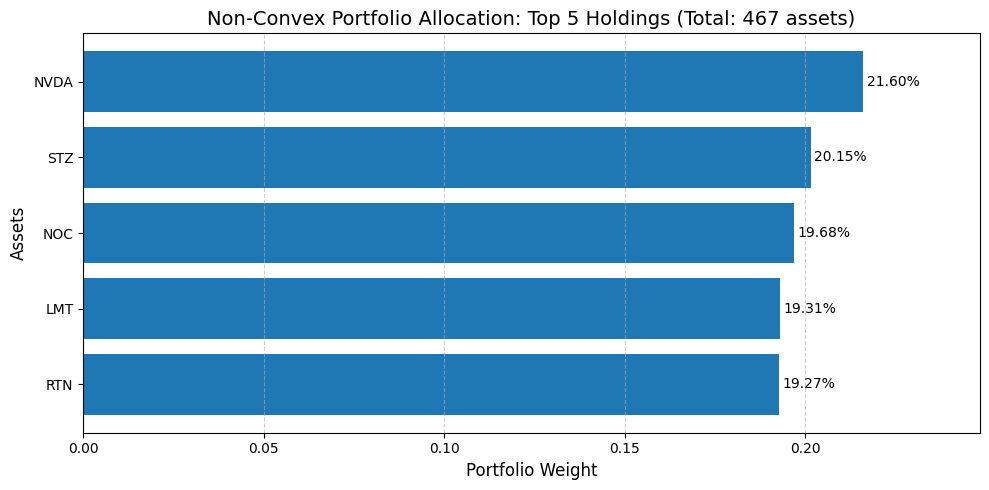


Top Holdings Summary:
NVDA   21.60%
STZ    20.15%
NOC    19.68%
LMT    19.31%
RTN    19.27%


In [7]:
# --- Visualization of Top 5 Non-Convex Portfolio Weights (Horizontal Bar Chart) ---

# 1. Convert weights to a Pandas Series for easy sorting and handling
weights_series = pd.Series(np.asarray(weights).flatten(), index=tickers).fillna(0)

# 2. Select the Top N assets and group the rest into 'Others'
top_n = 5
top_weights = weights_series.sort_values(ascending=False).head(top_n)

# Calculate sum of remaining weights (if any)
others_sum = weights_series.sort_values(ascending=False).iloc[top_n:].sum()

# Create the plotting Series
if abs(others_sum) > 1e-6 and len(weights_series) > top_n:
    # Concatenate top N with the 'Others' category
    plot_series = pd.concat([top_weights, pd.Series({'Others': others_sum})])
else:
    # If fewer than N stocks, just use the top_weights
    plot_series = top_weights.copy()

# Sort weights ascendingly for plotting (so the largest bar is at the top of the horizontal chart)
plot_series_sorted = plot_series.sort_values(ascending=True)

# 3. Create the Horizontal Bar Plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Use barh for horizontal bars (easier to read long ticker names)
bars = ax.barh(
    plot_series_sorted.index, 
    plot_series_sorted.values,
    # Color coding: blue for stocks, gray for 'Others'
    color=['#7f7f7f' if lbl == 'Others' else '#1f77b4' for lbl in plot_series_sorted.index]
)

# Annotate values on bars
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + 0.001, # x position (just right of the bar)
        bar.get_y() + bar.get_height() / 2, # y position (center of the bar)
        f'{width:.2%}', # Format as percentage
        ha='left', 
        va='center',
        fontsize=10
    )

# Set labels and title
ax.set_title(f"Non-Convex Portfolio Allocation: Top {top_n} Holdings (Total: {len(tickers)} assets)", fontsize=14)
ax.set_xlabel("Portfolio Weight", fontsize=12)
ax.set_ylabel("Assets", fontsize=12)
ax.set_xlim(right=plot_series_sorted.max() * 1.15) # Extend x-axis slightly for labels

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Display the top contributors in a table
print("\nTop Holdings Summary:")
print(plot_series.sort_values(ascending=False).to_string(float_format="{:.2%}".format))